# Part 5: N-BEATS
source and code: [N-BEATS Unleashed](https://towardsdatascience.com/n-beats-unleashed-deep-forecasting-using-neural-basis-expansion-analysis-in-python-343dd6307010)

N-beats model achitecture

In [70]:
# import package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import missingno as mno

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel
from darts.metrics import mape, rmse
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.statistics import check_seasonality


pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [71]:
LOAD = False         # True = load previously saved model from disk?  False = (re)train the model
SAVE = ".\..\model\_NBEATS_rss_model.pth.tar"   # file name to save the model under

EPOCHS = 20
INLEN = 16        # input size
BLOCKS = 16         
LWIDTH = 32
BATCH = 4          # batch size
LEARN = 1e-4        # learning rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
N_FC = 1            # output size

RAND = 42           # random seed
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = -1          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

SPLIT = 0.9        # train/test %

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

mpath = os.path.abspath(os.getcwd()) + SAVE     # path and file name to save the model

## Data Preparation

In [72]:
# create function for import dataset and set date as index
def import_csv_dateindex(csv_file):
    """
    take path of csv file and return df which date col as index
    """
    df = pd.read_csv(f'../data/{csv_file}')
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date').asfreq('B')
    return df

In [73]:
# import dataset
rubber = import_csv_dateindex('../data/rubber.csv')
rubber.drop('usd', axis=1, inplace=True)

In [74]:
rubber['cup_lump'].fillna(method='bfill', inplace=True)

In [75]:
rubber.head()

,cup_lump,rubber_sheet,ribbed_smoked_sheet,latex,fob,tocom,sicom,jpy,sgd,crude_oil
date,,,,,,,,,,
2017-09-19,36.00,52.56,55.04,51.50,60.10,208.80,174.30,3.37,24.56,51.77
2017-09-20,36.00,51.51,53.28,50.50,59.70,210.00,178.20,3.39,24.54,51.79
2017-09-21,36.00,51.51,53.14,50.00,59.70,207.80,175.30,3.40,24.53,51.63
2017-09-22,36.00,51.78,53.30,50.00,58.70,207.00,176.50,3.39,24.58,51.67
2017-09-25,36.00,50.58,53.22,50.00,58.70,207.00,178.00,3.38,24.50,51.41


In [76]:
rubber_lag = rubber.shift(21).copy()

In [77]:
rubber_train = pd.concat([rubber[['ribbed_smoked_sheet']], rubber_lag.drop('ribbed_smoked_sheet', axis=1)], axis=1)
rubber_train.dropna(inplace=True)

In [78]:
# create time series object for target variable
ts_P = TimeSeries.from_series(rubber_train["ribbed_smoked_sheet"], freq='B') 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['ribbed_smoked_sheet'], dtype='object', name='component')
duration: 1839 days 00:00:00
frequency: <BusinessDay>
frequency: B
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [79]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(split_point=SPLIT)
print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)

training start: 2017-10-18 00:00:00
training end: 2022-04-28 00:00:00
training duration: 1653 days 00:00:00
test start: 2022-04-29 00:00:00
test end: 2022-10-31 00:00:00
test duration: 185 days 00:00:00


In [80]:
# standardize features
scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

print("first and last row of scaled price time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

first and last row of scaled price time series:


component,ribbed_smoked_sheet
date,
2017-10-18,0.33
2022-10-31,0.29


In [81]:
# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

### Covariates

In [82]:
# create time series object for the feature columns
df_covF = rubber_train.loc[:, rubber_train.columns != "ribbed_smoked_sheet"]
ts_covF = TimeSeries.from_dataframe(df_covF)

# check attributes of the time series
print("components (columns) of feature time series:", ts_covF.components)
print("duration:",ts_covF.duration)
print("frequency:",ts_covF.freq)
print("frequency:",ts_covF.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_covF.has_datetime_index)
print("deterministic:",ts_covF.is_deterministic)
print("univariate:",ts_covF.is_univariate)

components (columns) of feature time series: Index(['cup_lump', 'rubber_sheet', 'latex', 'fob', 'tocom', 'sicom', 'jpy',
       'sgd', 'crude_oil'],
      dtype='object', name='component')
duration: 1839 days 00:00:00
frequency: <BusinessDay>
frequency: B
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: False


In [83]:
# train/test split and scaling of feature covariates
covF_train, covF_test = ts_covF.split_after(SPLIT)

scalerF = Scaler()
scalerF.fit_transform(covF_train)
covF_ttrain = scalerF.transform(covF_train) 
covF_ttest = scalerF.transform(covF_test)   
covF_t = scalerF.transform(ts_covF)  

# make sure data are of type float
covF_ttrain = covF_ttrain.astype(np.float32)
covF_ttest = covF_ttest.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled feature covariates:")
covF_t.pd_dataframe().iloc[[0,-1]]

first and last row of scaled feature covariates:


component,cup_lump,rubber_sheet,latex,fob,tocom,sicom,jpy,sgd,crude_oil
date,,,,,,,,,
2017-10-18,0.34,0.41,0.45,0.40,0.38,0.29,0.32,0.86,0.28
2022-10-31,0.57,0.26,0.31,0.39,0.46,0.13,1.36,1.44,0.71


In [84]:
# feature engineering - create time covariates: hour, weekday, month, quarter, year
# 41 days (2 months) beyond end of test set to prepare for out-of-sample forecasting
covT = datetime_attribute_timeseries(ts_P.time_index, attribute="day", one_hot=True, add_length=22) 
covT = covT.stack(  datetime_attribute_timeseries(covT.time_index, one_hot=True, attribute="month")  )
covT = covT.stack(  datetime_attribute_timeseries(covT.time_index, one_hot=True, attribute="quarter")  )
covT = covT.astype(np.float32)


covT_t = covT.copy()
covT_t = covT_t.astype(np.float32)


pd.options.display.float_format = '{:.0f}'.format
print("first and last row of unscaled time covariates:")
covT.pd_dataframe().iloc[[0,-1]]

first and last row of unscaled time covariates:


component,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,...,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
time,,,,,,,,,,,,,,,,,,,,,
2017-10-18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2022-11-30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [85]:
# combine feature and time covariates along component dimension: axis=1
ts_cov = ts_covF.concatenate( covT.slice_intersect(ts_covF), axis=1 )                      # unscaled F+T
cov_t = covF_t.concatenate( covT_t.slice_intersect(covF_t), axis=1 )                       # scaled F+T
cov_t = cov_t.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of unscaled covariates:")
ts_cov.pd_dataframe().iloc[[0,-1]]

first and last row of unscaled covariates:


component,cup_lump,rubber_sheet,latex,fob,tocom,sicom,jpy,sgd,crude_oil,day_1,...,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,
2017-10-18,36.00,52.56,51.50,60.10,208.80,174.30,3.37,24.56,51.77,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
2022-10-31,42.00,46.51,45.70,59.60,226.00,148.30,3.82,26.31,78.72,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00


In [86]:
# config model
model = NBEATSModel(    
    input_chunk_length=INLEN,
                        output_chunk_length=N_FC, 
                        num_stacks=BLOCKS,
                        layer_widths=LWIDTH,
                        batch_size=BATCH,
                        n_epochs=EPOCHS,
                        nr_epochs_val_period=VALWAIT, 
                        likelihood=QuantileRegression(QUANTILES), 
                        optimizer_kwargs={"lr": LEARN}, 
                        model_name="NBEATS_RSS",
                        log_tensorboard=True,
                        generic_architecture=True, 
                        random_state=RAND,
                        force_reset=True,
                        save_checkpoints=True
                    )

In [87]:
# training: load a saved model or (re)train
if LOAD:
    print("have loaded a previously saved model from disk:" + mpath)
    model = NBEATSModel.load_model(mpath)                            # load previously model from disk 
else:
    model.fit(  series=ts_ttrain, 
                past_covariates=covT_t,
                val_series=ts_ttest, 
                val_past_covariates=covT_t, 
                verbose=True)
    print("have saved the model after training:", mpath)
    model.save_model(mpath)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

have saved the model after training: D:\tda\dsi\capstone\code.\..\model\_NBEATS_rss_model.pth.tar


In [88]:
# testing: generate predictions
ts_tpred = model.predict(   n=len(ts_ttest),  
                            past_covariates=covT_t,
                            num_samples=N_SAMPLES,   
                            n_jobs=N_JOBS, 
                            verbose=True)
                            
                            
                            
# retrieve forecast series for chosen quantiles, 
# inverse-transform each series,
# insert them as columns in a new dataframe dfY
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
pd.options.display.float_format = '{:,.2f}'.format
dfY = pd.DataFrame()
dfY["Actual"] = TimeSeries.pd_series(ts_test['ribbed_smoked_sheet'])


# helper function: get forecast values for selected quantile q and insert them in dataframe dfY
def predQ(ts_t, q):
    ts_tq = ts_t.quantile_timeseries(q)
    ts_q = scalerP.inverse_transform(ts_tq)
    s = TimeSeries.pd_series(ts_q)
    header = "Q" + format(int(q*100), "02d")
    dfY[header] = s
  
# call helper function predQ, once for every quantile
_ = [predQ(ts_tpred['ribbed_smoked_sheet'], q) for q in QUANTILES]

# move Q50 column to the left of the Actual column
col = dfY.pop("Q50")
dfY.insert(1, col.name, col)
dfY.iloc[np.r_[0:2, -2:0]]

Predicting: 292it [00:00, ?it/s]

,Actual,Q50,Q01,Q10,Q20,Q80,Q90,Q99
date,,,,,,,,
2022-04-29,65.27,71.69,60.56,61.01,66.91,72.16,73.34,75.47
2022-05-02,65.27,71.92,61.35,62.56,67.98,72.34,72.90,75.84
2022-10-28,49.76,53.64,41.49,47.14,49.22,61.46,64.67,69.35
2022-10-31,49.47,56.16,42.19,48.71,51.99,64.94,68.00,73.39


In [89]:
# check MAPE scores from all quantile range
for col in dfY.columns:
    print(f"mape {col} {mape(TimeSeries.from_series(dfY['Actual'], freq='B'), TimeSeries.from_series(dfY[col], freq='B'))}")

mape Actual 0.0
mape Q50 6.503413906940329
mape Q01 18.015606298579744
mape Q10 13.373953123997188
mape Q20 9.6108983898589
mape Q80 6.298425069879155
mape Q90 7.906701406853333
mape Q99 10.306129398518204


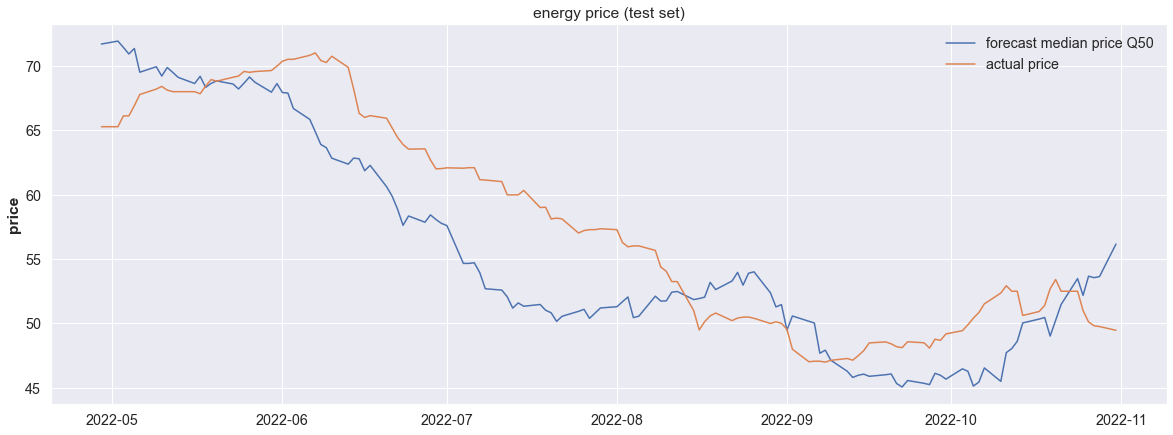

In [90]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
sns.set(font_scale=1.3)
p = sns.lineplot(x = "date", y = "Q50", data = dfY, palette="coolwarm")
sns.lineplot(x = "date", y = "Actual", data = dfY, palette="coolwarm")
plt.legend(labels=["forecast median price Q50", "actual price"])
p.set_ylabel("price")
p.set_xlabel("")
p.set_title("rss price (test set)");

In [91]:
# choose forecast horizon: 1 months(november) beyond end of test set
k = 22   

n_FC = k + len(ts_ttest)   # length of test set + k hours
print("forecast beyond end of training set:", n_FC, 
      "days beyond", ts_ttrain.end_time())

# last 22 days of feature covariates available => copy them to future 22 days:
covF_t_fut = covF_t.concatenate(    other=covF_t.tail(size=22), 
                                    ignore_time_axis=True)

# pull covariates in month october for predict november
df_covF_fut = rubber.loc[:, rubber.columns != "ribbed_smoked_sheet"]
df_covF_fut = df_covF_fut.shift(22).dropna()
ts_covF_fut = TimeSeries.from_dataframe(df_covF_fut)
covF_t_fut = scalerF.transform(ts_covF)  


# combine feature and time covariates:
cov_t_fut = covF_t_fut.concatenate(covT_t.slice_intersect(covF_t_fut), axis=1) 
cov_t_fut.pd_dataframe().iloc[[0,-1]]

forecast beyond end of training set: 154 days beyond 2022-04-28 00:00:00


component,cup_lump,rubber_sheet,latex,fob,tocom,sicom,jpy,sgd,crude_oil,day_1,...,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,
2017-10-18,0.34,0.41,0.45,0.40,0.38,0.29,0.32,0.86,0.28,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
2022-10-31,0.57,0.26,0.31,0.39,0.46,0.13,1.36,1.44,0.71,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00


In [92]:
# forecast next 2 months
ts_tpred = model.predict(   n=n_FC, 
                            past_covariates=covT_t, 
                            num_samples=N_SAMPLES, 
                            verbose=True, 
                            n_jobs=N_JOBS)
print("start:", ts_tpred.start_time(), "; end:",ts_tpred.end_time())

Predicting: 292it [00:00, ?it/s]

start: 2022-04-29 00:00:00 ; end: 2022-11-30 00:00:00


In [93]:
# retrieve forecast series for chosen quantiles, 
# inverse-transform each series,
# insert them as columns in a new dataframe dfY
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
pd.options.display.float_format = '{:,.2f}'.format
dfY = pd.DataFrame()
 
# call helper function predQ, once for every quantile
_ = [predQ(ts_tpred, q) for q in QUANTILES]

# move Q50 column to the left, then insert Actual column
col = dfY.pop("Q50")
dfY.insert(0, col.name, col)
dfY.insert(0, "Actual", TimeSeries.pd_series(ts_test))

# show first and last 13 timestamps of forecast
dfY.iloc[np.r_[0:1, -13:0]]  

,Actual,Q50,Q01,Q10,Q20,Q80,Q90,Q99
date,,,,,,,,
2022-04-29,65.27,71.69,60.60,61.93,65.82,72.05,73.47,75.39
2022-11-14,NaN,54.27,43.81,47.33,49.11,59.90,62.62,65.02
2022-11-15,NaN,53.59,43.60,47.03,48.81,60.33,61.87,65.90
2022-11-16,NaN,53.81,43.78,48.08,49.64,59.66,61.76,65.49
2022-11-17,NaN,54.69,44.97,47.81,49.36,59.45,61.70,65.72
2022-11-18,NaN,53.30,44.07,46.72,48.87,60.02,62.60,65.01
2022-11-21,NaN,54.40,42.09,46.80,48.62,59.75,61.43,62.90
2022-11-22,NaN,55.34,41.56,47.96,49.90,60.70,61.98,64.64
2022-11-23,NaN,57.29,42.85,48.08,51.31,62.82,63.90,65.68


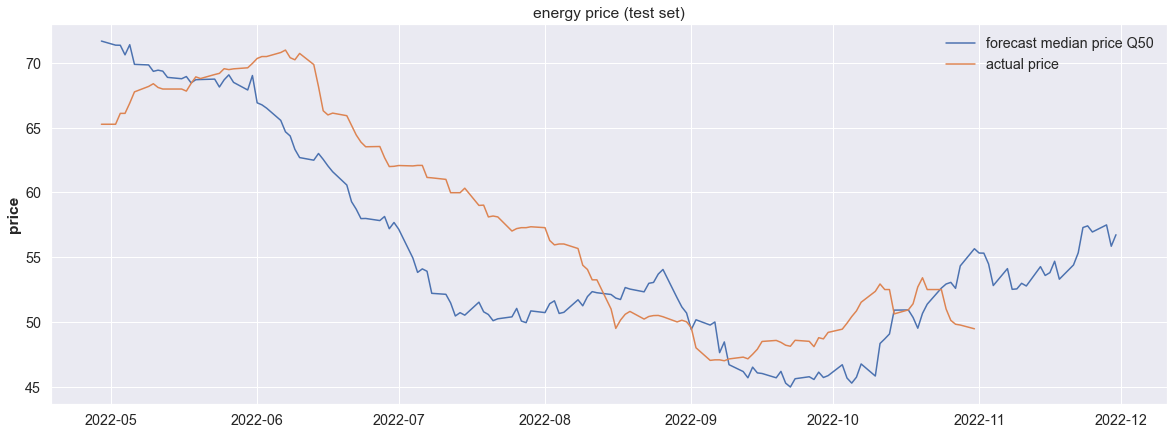

In [94]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
sns.set(font_scale=1.3)
p = sns.lineplot(x = "date", y = "Q50", data = dfY, palette="coolwarm")
sns.lineplot(x = "date", y = "Actual", data = dfY, palette="coolwarm")
plt.legend(labels=["forecast median price Q50", "actual price"])
p.set_ylabel("price")
p.set_xlabel("")
p.set_title("rss price preidction");

---

## Part 6: Conclusion